In [115]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#setup
import os, sys
current_path = os.path.abspath('')
parent_path = os.path.dirname(current_path)
source_path = f'{parent_path}\\src'
if not source_path in sys.path: sys.path.append(source_path)

#customs
# from data_model import *
# from data_helper import *
from config import *
setup()

Config finished!


In [116]:
df = pd.read_csv('./data/V1.ExaltedOrb.csv', index_col='Date', parse_dates=True)
df.head()

,Value,League,Confidence,LeagueDay
Date,,,,
2016-09-08,64.00417,Essence,0,1.0
2016-09-09,64.51451,Essence,0,2.0
2016-09-10,65.00280,Essence,0,3.0
2016-09-11,65.05764,Essence,0,4.0
2016-09-12,65.98811,Essence,0,5.0


In [117]:
def train_val_split(df, selected_features):
    is_last_league = df['League'] == Constants.LEAGUES[-1]

    df_selected = df[selected_features]
    df_train = df_selected[~is_last_league]
    df_val = df_selected[is_last_league]
    return df_train, df_val
def print_train_val_stats(train,val):
    print('shapes: ', train.shape, val.shape)
    display(train.head())
    display(val.head())

In [118]:
df_train, df_val = train_val_split(df, ['Value','LeagueDay','Confidence'])
print_train_val_stats(df_train, df_val)

shapes:  (1719, 3) (88, 3)


,Value,LeagueDay,Confidence
Date,,,
2016-09-08,64.00417,1.0,0
2016-09-09,64.51451,2.0,0
2016-09-10,65.00280,3.0,0
2016-09-11,65.05764,4.0,0
2016-09-12,65.98811,5.0,0


,Value,LeagueDay,Confidence
Date,,,
2021-07-23,50.00000,1.0,1
2021-07-24,62.00000,2.0,0
2021-07-25,72.57994,3.0,0
2021-07-26,77.00000,4.0,0
2021-07-27,75.91450,5.0,0


In [119]:
# from sklearn.base import BaseEstimator, ClassifierMixin

# class BoostedHybrid(BaseEstimator, ClassifierMixin):
#     def __init__(self, model_1, model_2):
#         self.model_1 = model_1
#         self.model_2 = model_2
#         self.y_columns = None  # store column names from fit method
    
#     def checkDataFrameInput(self, *df_inputs):
#         last_df = df_inputs[-1]
#         for i, df in enumerate(df_inputs[:-1]):
#             if (last_df.index != df.index).any():
#                 raise Exception(f'Input dataframes must have same index ({i}, {len(df_inputs) - 1})')
#     def fit(self, X_1_and_2, y):
#         self.checkDataFrameInput(*X_1_and_2, y)
#         X_1, X_2 = X_1_and_2

#         self.model_1.fit(X_1,y)
#         y_fit = pd.DataFrame(
#             self.model_1.predict(X_1),
#             index=X_1.index, columns=y.columns,
#         )

#         y_resid = y - y_fit

#         self.model_2.fit(X_2, y_resid)

#         # Save column names for predict method
#         self.y_columns = y.columns
#         return self

#     def predict(self, X_1_and_2):
#         self.check_is_fitted()
        
#         self.checkDataFrameInput(*X_1_and_2)
#         X_1, X_2 = X_1_and_2

#         y_pred_trend = pd.DataFrame(
#             self.model_1.predict(X_1),
#             index=X_1.index, columns=self.y_columns,
#         )
#         y_pred_resid = pd.DataFrame(
#             self.model_2.predict(X_2),
#             index=X_2.index, columns=self.y_columns,
#         )

#         return y_pred_trend + y_pred_resid

In [120]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)
def make_multi_target(ts, steps, lead_time=1):
    return pd.concat(
        {
            f'y_step_{i}': ts.shift(-i)
            for i in range(lead_time, steps + lead_time)
        },
        axis=1)


In [121]:
from statsmodels.tsa.deterministic import DeterministicProcess

class FeatureEngineer:
    def trend_features(self, df, training = True):
        if training:
            self.dp = DeterministicProcess(
                index = df.index,
                order = 4,
                drop = True
            )
            X = self.dp.in_sample().fillna(0)
        else:
            X = self.dp.out_of_sample(df.shape[0]).fillna(0)
        
        return X
    def residual_features(self, df, training = True, lags = 4):
        if training:
            self.dp = DeterministicProcess(
                index = df.index,
                order = 1,
                drop = True
            )
            index_features = self.dp.in_sample().fillna(0)
        else:
            index_features = self.dp.out_of_sample(df.index).fillna(0)

        lags = make_lags(df['Value'], lags).fillna(0)
        selected_features = df[['Confidence', 'LeagueDay']]
        return pd.concat(
            [index_features, lags, selected_features],
            axis = 1
        )
    def target(self, df, steps = 5):
        return make_multi_target(df['Value'], steps).fillna(0)

In [122]:
feature_engineer = FeatureEngineer()
X_train_trend, X_train_resid, y_train = [
    feature_engineer.trend_features(df_train),
    feature_engineer.residual_features(df_train),
    feature_engineer.target(df_train)
]
for x in [X_train_trend, X_train_resid, y_train]:
    print(x.shape)
    display(x.head())
    display(x.isna().sum().sum())

(1719, 4)


,trend,trend_squared,trend_cubed,trend**4
Date,,,,
2016-09-08,1.0,1.0,1.0,1.0
2016-09-09,2.0,4.0,8.0,16.0
2016-09-10,3.0,9.0,27.0,81.0
2016-09-11,4.0,16.0,64.0,256.0
2016-09-12,5.0,25.0,125.0,625.0


0

(1719, 7)


,trend,y_lag_1,y_lag_2,y_lag_3,y_lag_4,Confidence,LeagueDay
Date,,,,,,,
2016-09-08,1.0,0.00000,0.00000,0.00000,0.00000,0,1.0
2016-09-09,2.0,64.00417,0.00000,0.00000,0.00000,0,2.0
2016-09-10,3.0,64.51451,64.00417,0.00000,0.00000,0,3.0
2016-09-11,4.0,65.00280,64.51451,64.00417,0.00000,0,4.0
2016-09-12,5.0,65.05764,65.00280,64.51451,64.00417,0,5.0


0

(1719, 5)


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2016-09-08,64.51451,65.00280,65.05764,65.98811,66.01724
2016-09-09,65.00280,65.05764,65.98811,66.01724,69.08462
2016-09-10,65.05764,65.98811,66.01724,69.08462,69.83986
2016-09-11,65.98811,66.01724,69.08462,69.83986,68.44797
2016-09-12,66.01724,69.08462,69.83986,68.44797,66.80162


0

In [123]:
from sklearn.multioutput import RegressorChain
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
model = RegressorChain(base_estimator= XGBRegressor())

In [124]:
model.fit(X_train_resid, y_train)
pred = pd.DataFrame(
    model.predict(X_train_resid),
    index = df_train.index,
    columns = y_train.columns
)
pred.head()

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2016-09-08,63.706745,64.869400,65.498589,66.155182,66.079536
2016-09-09,65.236427,65.222534,65.961159,66.135292,68.883369
2016-09-10,65.645859,66.796654,67.048416,68.636795,67.409920
2016-09-11,66.352905,66.097977,68.791031,69.895706,68.686699
2016-09-12,66.004944,68.683998,69.900002,68.854080,67.742599


In [125]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
def evaluate(model, X_val, y_val):
    pred = model.predict(X_val)
    mse = mean_squared_error(pred, y_val)
    mape = mean_absolute_percentage_error(pred, y_val)
    print('Result - MSE: ', mse, ' - MAPE: ', mape)

In [126]:
evaluate(model, X_train_resid, y_train)

Result - MSE:  28.291011515677013  - MAPE:  0.028458404925823466


In [127]:
# df_train['Value'].plot(label='Value')
# pred.plot()

In [128]:
X_val_trend, X_val_resid, y_val = [
    feature_engineer.trend_features(df_val),
    feature_engineer.residual_features(df_val),
    feature_engineer.target(df_val)
]
for x in [X_val_trend, X_val_resid, y_val]:
    print(x.shape)
    # display(x.head())
    display(x.isna().sum().sum())

(88, 4)


0

(88, 7)


0

(88, 5)


0

In [129]:
evaluate(model, X_val_resid, y_val)

Result - MSE:  1067.8023182345921  - MAPE:  0.2893866551076157


In [130]:
pred_val = pd.DataFrame(
    model.predict(X_val_resid),
    index = df_val.index, columns = y_val.columns
)

In [131]:
# for i in range(1, 6):
#     name = f'y_step_{i}'
#     real = y_val[name]
#     pred = pred_val[name]
#     real.plot(label=f'{name}-Real')
#     pred.plot(label=f'{name}-Pred')
#     plt.legend()
#     plt.show()

In [132]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

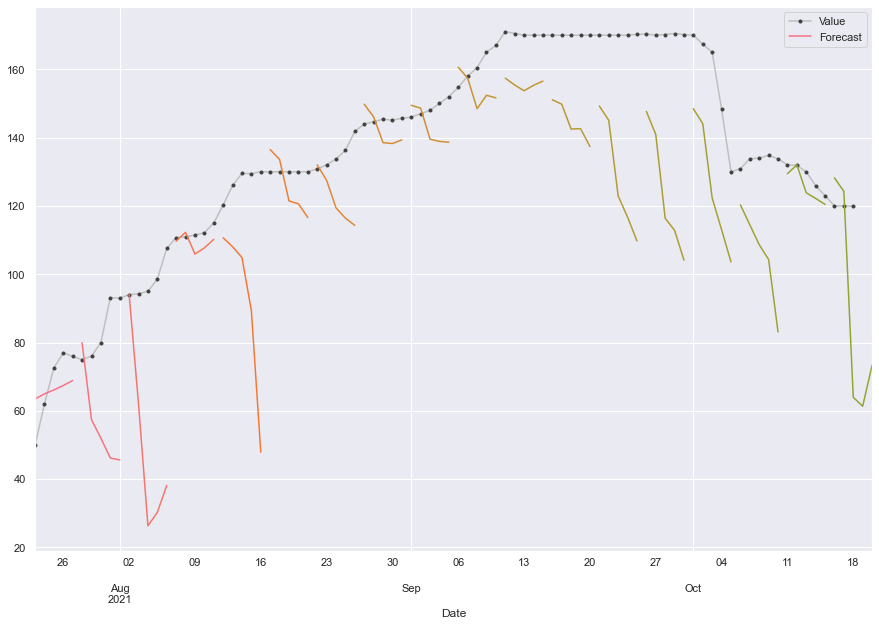

In [133]:
pred = pd.DataFrame(
    model.predict(X_train_resid),
    index = df_train.index, columns = y_train.columns
)
palette = dict(palette='husl', n_colors=64)
ax2 = df_val['Value'].plot(**plot_params)
ax2 = plot_multistep(pred_val, ax=ax2, palette_kwargs=palette, every=5)
_ = ax2.legend(['Value', 'Forecast'])

plt.show()

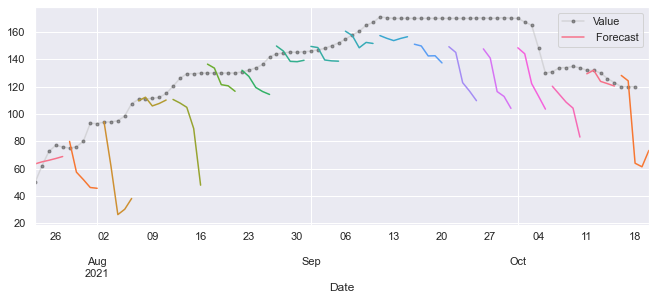

In [134]:
START = y_val.index[0]
EVERY = 5
y_pred_ = pred_val.loc[START:]
y_ = df_val.loc[START:, 'Value']

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend(['Value',' Forecast'])